In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

Question 5

In [3]:
for N in range(2, 41):
    is_prime = True
    for i in range(2, N):
        if N % i == 0:
            is_prime = False
            break
    if is_prime:
        print(N)

2
3
5
7
11
13
17
19
23
29
31
37


Question 6

In [4]:
primes = []
for N in range(2, 41):
    is_prime = True
    for i in range(2, N):
        if N % i == 0:
            is_prime = False
            break
    if is_prime:
        primes.append(N)

print(primes[::-1][:5])

[37, 31, 29, 23, 19]


Question 7

In [5]:
path = "data_etc/math.txt"

with open(path, 'r') as f:
    equations = f.readlines()

with open("solved_equations.txt", 'w') as f:
    for eq in equations:
        a, b = eq.split("=")[0].split('+')
        result = int(a) + int(b)

        # Husk at fjerne newline!
        f.write(f"{eq[:-1]} {result}\n")

Question 8 & 9: 

See respective files.

Question 10: 

In [6]:
valid = 0
with open("data_etc/names.txt", 'r') as f:
    for line in f:
        policy, password = line.split(': ')
        min_max, letter = policy.split()
        min_count, max_count = map(int, min_max.split('-'))
        count = password.count(letter)
        if min_count <= count <= max_count:
            valid += 1
print(f"Valid passwords: {valid}")

Valid passwords: 506


Question 11 

Text(0.5, 1.0, 'Spectrum from data_etc/sdssJ133702+305539_combined.dat')

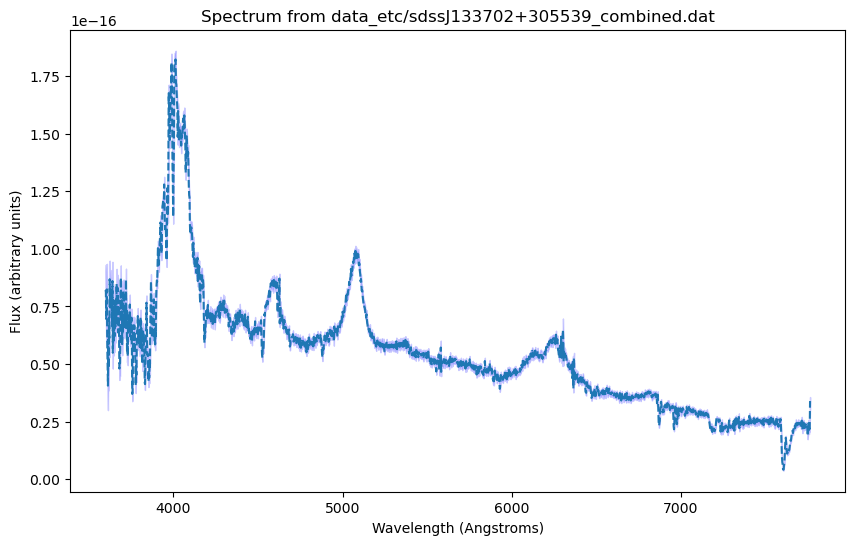

In [7]:
path = "data_etc/sdssJ133702+305539_combined.dat"

data = np.genfromtxt(path,  skip_header=1, delimiter=' ')

data[:,2] = np.sqrt(data[:,2])
plt.figure(figsize=(10,6))
plt.plot(data[:,0], data[:,1], '--')
plt.fill_between(data[:,0], data[:,1]-data[:,2], data[:,1]+data[:,2], color='blue', alpha=0.2)
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux (arbitrary units)")
plt.title("Spectrum from " + path)

Question 12:

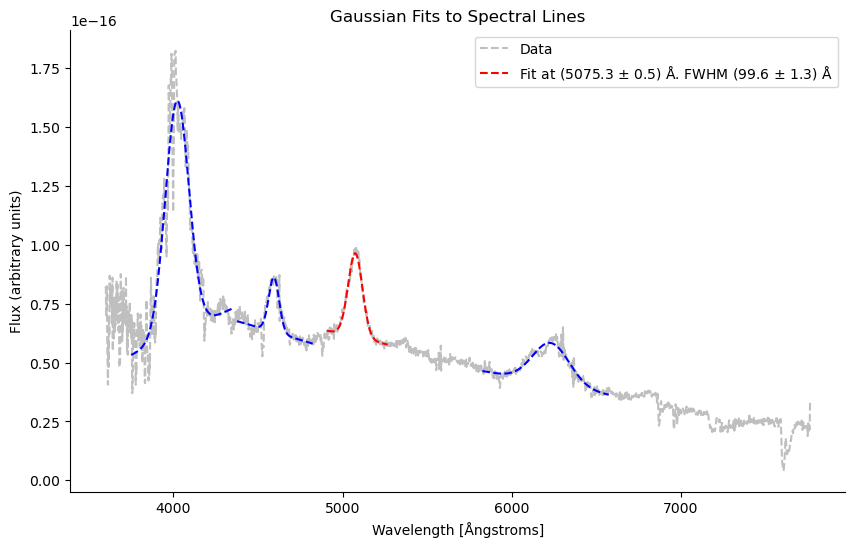

In [13]:
fitpeaks = [4050, 4600, 5087, 6200]
fit_widths = [200, 150, 120, 250]
fit_widths = np.array(fit_widths)*1.5


N = 2

def gaussian_on_linear_bg(x, amp, cen, wid, slope, intercept):
    return amp * np.exp(-(x-cen)**2 / (2*wid**2)) + slope*x + intercept

plt.figure(figsize=(10,6))
from scipy.optimize import curve_fit
plt.plot(data[:,0], data[:,1], '--', label='Data', alpha=0.5, c ='gray')
for peak, width in zip(fitpeaks, fit_widths):
    mask = (data[:,0] > peak - width) & (data[:,0] < peak + width)
    xdata = data[mask, 0]
    ydata = data[mask, 1]
    yerr = data[mask, 2]

    p0 = [np.max(ydata), peak, width/2, 0, np.median(ydata)]
    popt, pcov = curve_fit(gaussian_on_linear_bg, xdata, ydata, p0=p0, sigma=yerr)

    fitpeak = popt[1]
    fitwidth = popt[2]

    # Convert sigma to FWHM
    fwhm = 2 * np.sqrt(2 * np.log(2)) * fitwidth
    fwhm_uncertainty = 2 * np.sqrt(2 * np.log(2)) * np.sqrt(pcov[2,2])

    if N == 0:
        c = "r"
        label = f'Fit at ({fitpeak:.1f} $\\pm$ {np.sqrt(pcov[1,1]):.1f}) Å. FWHM ({np.abs(fwhm):.1f} $\\pm$ {fwhm_uncertainty:.1f}) Å'
    else:
        c = "b"
        label = None
        #add fit to legend

    plt.plot(xdata, gaussian_on_linear_bg(xdata, *popt), c+'--', label=label)
    N -= 1
plt.xlabel("Wavelength [Ångstroms]")
plt.ylabel("Flux (arbitrary units)")
plt.title("Gaussian Fits to Spectral Lines")
plt.legend()
sns.despine()
plt.show()

Question 13:

### Error Propagation

Estimate the uncertainty by propagating the flux errors, assuming uncorrelated Gaussian noise:


 $\mathrm{Var}(I_i) = \sigma_{I_i}^2$.

Using standard first-order error propagation:

$$\mathrm{Var}(f) = \sum_i \left( \frac{\partial f}{\partial I_i} \right)^2 \sigma_{I_i}^2$$

we differentiate the moment definitions with respect to each $I_i$:

$$\frac{\partial \mu}{\partial I_i} = \frac{\lambda_i - \mu}{\sum_j I_j}, \qquad \frac{\partial \sigma^2}{\partial I_i} = \frac{(\lambda_i - \mu)^2 - \sigma^2}{\sum_j I_j}$$

Substituting these into the propagation formula gives:

$$\mathrm{Var}(\mu) = \frac{\sum_i (\lambda_i - \mu)^2\, \sigma_{I_i}^2}{(\sum_i I_i)^2}, \qquad \mathrm{Var}(\sigma^2) = \frac{\sum_i [(\lambda_i - \mu)^2 - \sigma^2]^2 \sigma_{I_i}^2}{(\sum_i I_i)^2}$$

Finally, the uncertainties on $\sigma$ and the FWHM are easy to do (or I have forgotten how math works):

$$\sigma_\sigma = \frac{\sqrt{\mathrm{Var}(\sigma^2)}}{2\sigma}, \qquad \sigma_{\mathrm{FWHM}} = 2\sqrt{2\ln2}\;\sigma_\sigma$$

This is implemented below:


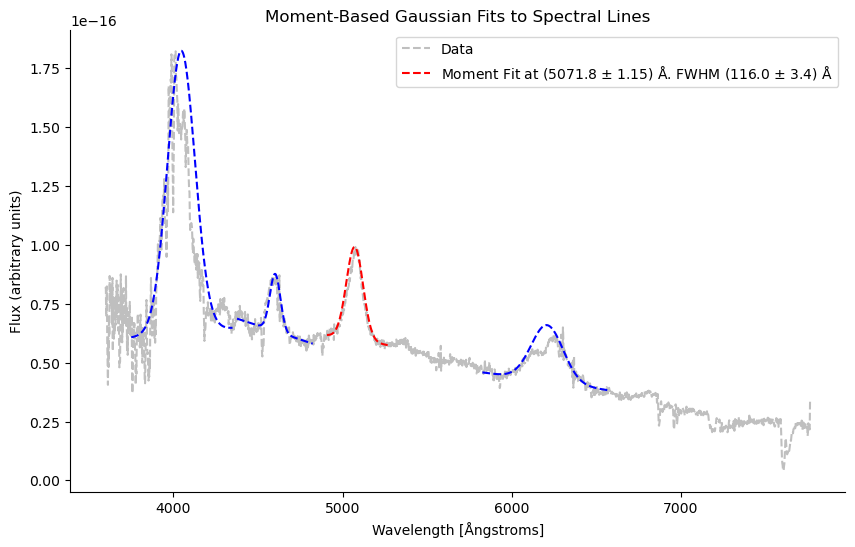

In [14]:
# usign moments
def moment_based_gaussian(x, y):
    """Estimate Gaussian parameters using moments."""
    total = np.sum(y)
    mean = np.sum(x * y) / total
    variance = np.sum(y * (x - mean)**2) / total
    return mean, np.sqrt(variance)



plt.figure(figsize=(10,6))

plt.plot(data[:,0], data[:,1], '--', label='Data', alpha=0.5, c ='gray')

N  = 2

for peak, width in zip(fitpeaks, fit_widths):
    mask = (data[:,0] > peak - width) & (data[:,0] < peak + width)
    xdata = data[mask, 0]
    ydata = data[mask, 1]

    # Find linear background from edges of the window
    left_edge = ydata[0]
    right_edge = ydata[-1]
    slope = (right_edge - left_edge) / (xdata[-1] - xdata[0])
    intercept = left_edge - slope * xdata[0]

    ydata_bgsub = ydata - (slope * xdata + intercept)

    # Estimate uncertainties via error propagation as defined in the cell above
    mean_mean, mean_stddev = moment_based_gaussian(xdata, ydata_bgsub)

    # Error propagation for moments
    total = np.sum(ydata_bgsub)
    mean = mean_mean
    variance = mean_stddev**2
    yerr = data[mask, 2]  # flux uncertainties

    # Var(μ) = Σ[(λ_i - μ)^2 * σ_{I_i}^2] / (Σ I_i)^2
    dmean_dy = (xdata - mean) / total
    var_mu = np.sum((dmean_dy**2) * (yerr**2))
    mean_uncertainty = np.sqrt(var_mu)

    # Var(σ²) = Σ{[(λ_i - μ)^2 - σ²]^2 * σ_{I_i}^2} / (Σ I_i)^2
    dvar_dy = ((xdata - mean)**2 - variance) / total
    var_sigma2 = np.sum((dvar_dy**2) * (yerr**2))
    sigma2_uncertainty = np.sqrt(var_sigma2)

    # Uncertainty on σ: σ_σ = sqrt(Var(σ²)) / (2σ)
    stddev_uncertainty = sigma2_uncertainty / (2 * mean_stddev)

    # Convert sigma to FWHM
    fwhm = 2 * np.sqrt(2 * np.log(2)) * mean_stddev
    fwhm_uncertainty = 2 * np.sqrt(2 * np.log(2)) * stddev_uncertainty

    gaussian_fit = np.max(ydata_bgsub) * np.exp(-(xdata - mean_mean)**2 / (2*mean_stddev**2)) + slope * xdata + intercept

    if N == 0:
        c = "r"
        label = f'Moment Fit at ({(mean_mean):.1f} $\\pm$ {mean_uncertainty:.2f}) Å. FWHM ({np.abs(fwhm):.1f} $\\pm$ {fwhm_uncertainty:.1f}) Å'
    else:
        c = "b"
        label = None
        #add fit to legen
    N -= 1

    plt.plot(xdata, gaussian_fit, c+'--', label  = label)

plt.xlabel("Wavelength [Ångstroms]")
plt.ylabel("Flux (arbitrary units)")
plt.title("Moment-Based Gaussian Fits to Spectral Lines")
plt.legend()
sns.despine()
plt.show()